In [ ]:
# Dataset : https://www.dropbox.com/home/Dataset.zip

!wget https://www.dropbox.com/s/kfykfe3rq931xeg/BrainTumorDataset.zip?dl=0

--2021-03-02 15:27:39--  https://www.dropbox.com/s/kfykfe3rq931xeg/BrainTumorDataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/kfykfe3rq931xeg/BrainTumorDataset.zip [following]
--2021-03-02 15:27:39--  https://www.dropbox.com/s/raw/kfykfe3rq931xeg/BrainTumorDataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc91ed43c0656a503bd69dd84c65.dl.dropboxusercontent.com/cd/0/inline/BJ74zUVjHKmVNFzVeHKCU0Q9ql3lXDp9Q7rpISLAEn4X0HqpK9B1zYY3bWjBqMtCWdeiikjV03UqRFuj1d395k9r27le2TzpXN2vuGiBSszY1wAKdcEXYgjTnBqD8gd1eEk/file# [following]
--2021-03-02 15:27:39--  https://uc91ed43c0656a503bd69dd84c65.dl.dropboxusercontent.com/cd/0/inline/BJ74zUVjHKmVNFzVeHKCU0Q9ql3lXDp9Q7rpISLAEn4X0HqpK9B1zYY3bWjBqMtCWdeiikjV03UqRFu

In [ ]:
!unzip BrainTumorDataset.zip

Archive:  BrainTumorDataset.zip
   creating: Dataset/no/
  inflating: Dataset/no/10 no.jpg    
  inflating: Dataset/no/11 no.jpg    
  inflating: Dataset/no/12 no.jpg    
  inflating: Dataset/no/13 no.jpg    
  inflating: Dataset/no/14 no.jpg    
  inflating: Dataset/no/15 no.jpg    
  inflating: Dataset/no/17 no.jpg    
  inflating: Dataset/no/18 no.jpg    
  inflating: Dataset/no/19 no.jpg    
  inflating: Dataset/no/1no.jpeg     
  inflating: Dataset/no/2 no.jpeg    
  inflating: Dataset/no/20 no.jpg    
  inflating: Dataset/no/21 no.jpg    
  inflating: Dataset/no/22 no.jpg    
  inflating: Dataset/no/23 no.jpg    
  inflating: Dataset/no/24 no.jpg    
  inflating: Dataset/no/25 no.jpg    
  inflating: Dataset/no/26 no.jpg    
  inflating: Dataset/no/27 no.jpg    
  inflating: Dataset/no/28 no.jpg    
  inflating: Dataset/no/29 no.jpg    
  inflating: Dataset/no/3 no.jpg     
  inflating: Dataset/no/30 no.jpg    
  inflating: Dataset/no/31 no.jpg    
  inflating: Dataset/no/32 no.j

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50

In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras import *
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
!apt-get install tree
#clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (95.8 kB/s)
Selecting previously unselected package tree.
(Reading database ... 149406 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
.
├── Dataset
│   ├── no
│   └── yes
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

13 directories


In [ ]:
IMG_PATH = 'Dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size=(299,299)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (299,299)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

100%|██████████| 2/2 [00:00<00:00, 14.09it/s]

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

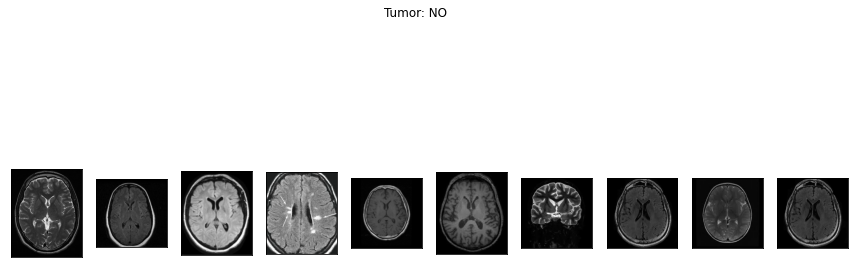

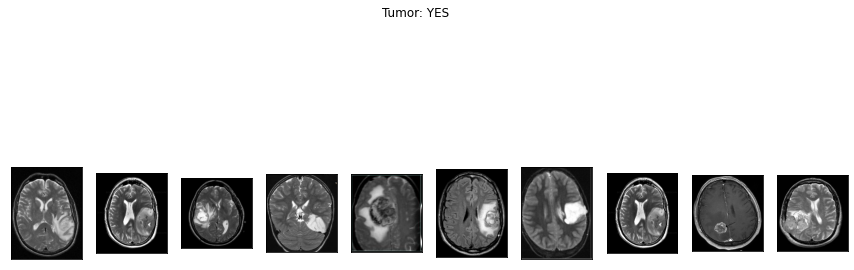

In [ ]:
plot_samples(X_train, y_train, labels, 10)

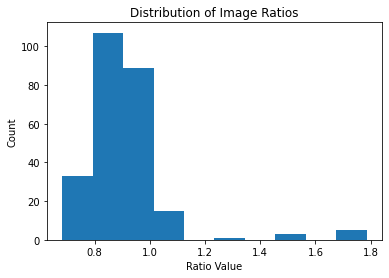

In [ ]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
img = cv2.imread('Dataset/yes/Y91.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

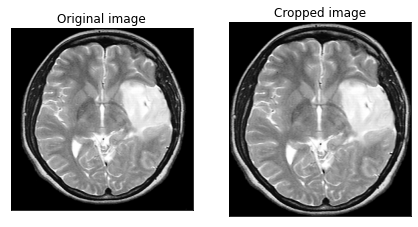

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Original image')
plt.subplot(142)
plt.imshow(new_img)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Cropped image')
plt.show()

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



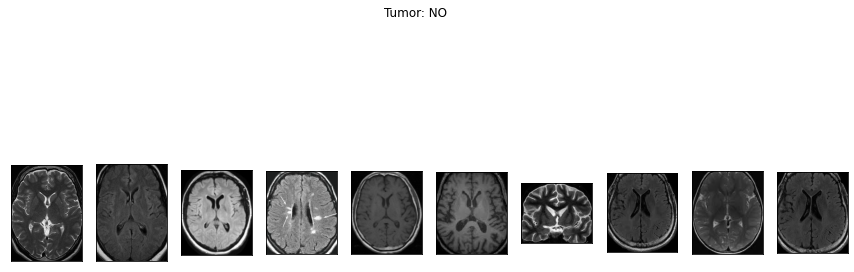

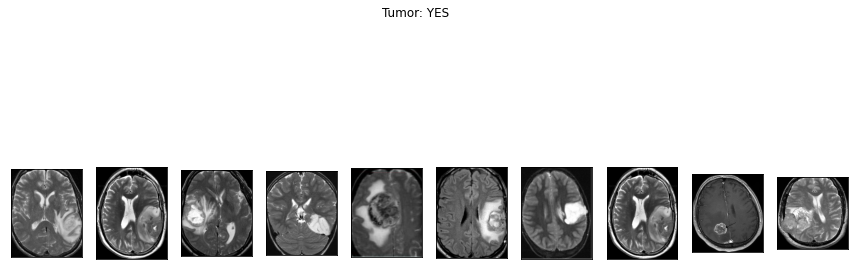

In [ ]:
plot_samples(X_train_crop, y_train, labels, 10)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [ ]:
def preprocess_imgs(set_name, img_size):
    
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

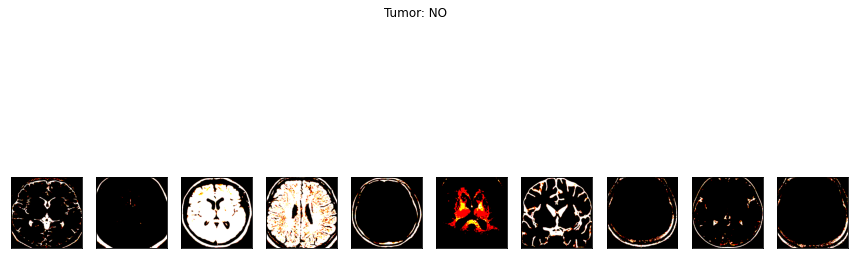

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

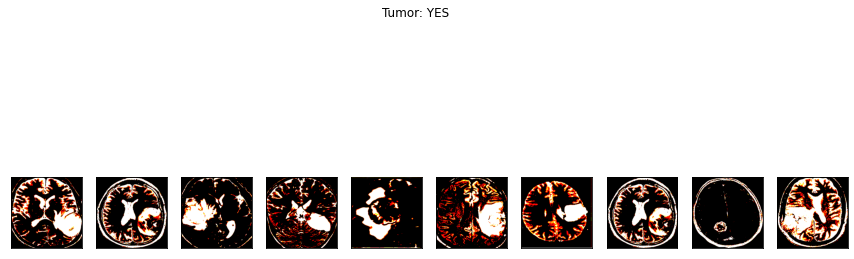

In [ ]:
 plot_samples(X_train_prep, y_train, labels, 10)

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
os.mkdir('preview')
x = X_train_crop[10]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

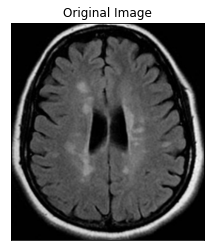

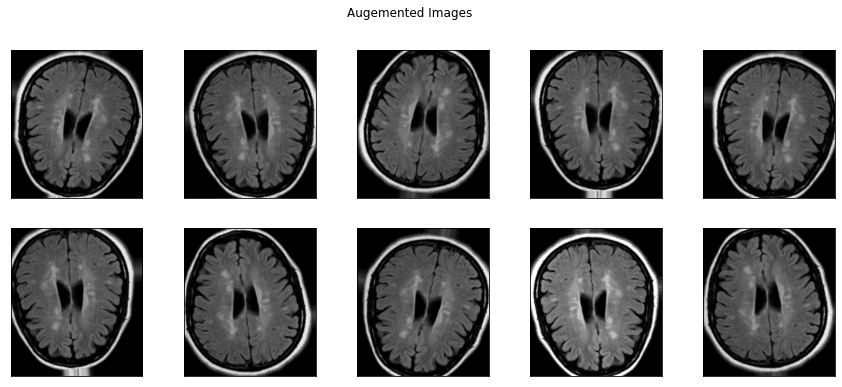

In [ ]:
plt.imshow(X_train_crop[10])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 2*5:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
!rm -rf preview/

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## InceptionV3

In [ ]:
# load base model
InceptionV3_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionV3 = InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = 1

inception_v3 = Sequential()
inception_v3.add(inceptionV3)
inception_v3.add(layers.Dropout(0.3))
inception_v3.add(layers.Flatten())
inception_v3.add(layers.Dropout(0.5))
inception_v3.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

inception_v3.layers[0].trainable = False

inception_v3.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

inception_v3.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


inception_v3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 131073    
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

inception_v3_history = inception_v3.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[early_stop]
)

end = time.time()
print(end - start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 54s 8s/step - loss: 59.1872 - accuracy: 0.4713 - val_loss: 9.3980 - val_accuracy: 0.5000
Epoch 2/50
6/6 [==============================] - 47s 8s/step - loss: 23.1521 - accuracy: 0.5247 - val_loss: 9.4837 - val_accuracy: 0.6000
Epoch 3/50
6/6 [==============================] - 47s 8s/step - loss: 19.9697 - accuracy: 0.5623 - val_loss: 20.5744 - val_accuracy: 0.6400
Epoch 4/50
6/6 [==============================] - 47s 8s/step - loss: 20.1186 - accuracy: 0.6768 - val_loss: 13.4567 - val_accuracy: 0.5800
Epoch 5/50
6/6 [==============================] - 47s 8s/step - loss: 18.6550 - accuracy: 0.5467 - val_loss: 8.3672 - val_accuracy: 0.6800
Epoch 6/50
6/6 [==============================] - 47s 8s/step - loss: 16.8483 - accuracy: 0.6086 - val_loss: 8.1259 - val_accuracy: 0.7200
Epoch 7/50
6/6 [==============================] - 47s 8s/step - loss: 11.0652 - accuracy: 0.7132 - val_loss: 8.8631 - val_accuracy: 0.6400
Epoch 8/50
6/6 [=========

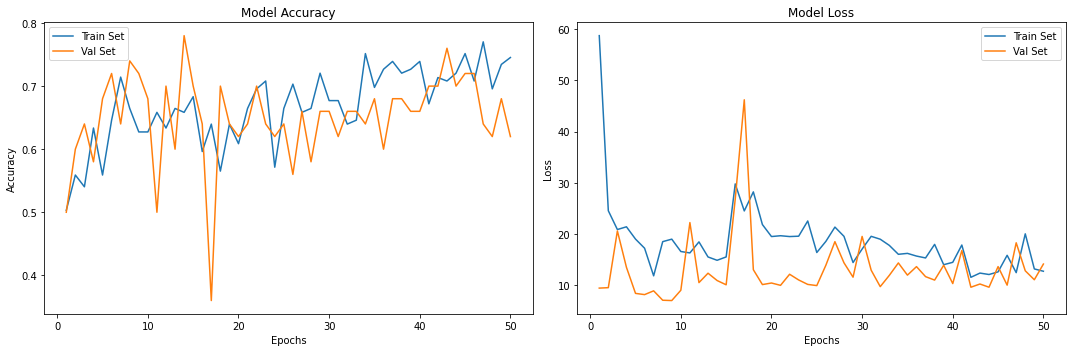

In [ ]:
# plot model performance
acc = inception_v3_history.history['accuracy']
val_acc = inception_v3_history.history['val_accuracy']
loss = inception_v3_history.history['loss']
val_loss = inception_v3_history.history['val_loss']
epochs_range = range(1, len(inception_v3_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.660000


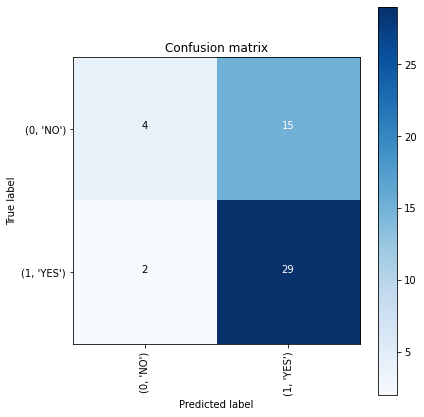

In [ ]:
# validate on val set
predictions = inception_v3.predict(X_val_prep)
predictions = [1 if x>0.95 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.660000
Precision: 0.659091
Recall: 0.935484
F1 score: 0.773333


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.168297
ROC AUC: 0.573005


Test Accuracy = 0.70


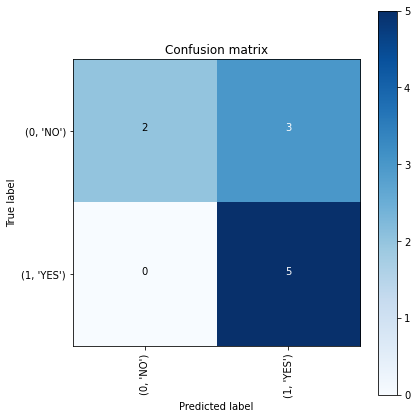

In [ ]:
# validate on test set
predictions = inception_v3.predict(X_test_prep)
predictions = [1 if x>0.95 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

## Xception

In [ ]:
# load base model
Xception_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
xception = Xception(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
NUM_CLASSES = 1

xception_ = Sequential()
xception_.add(xception)
xception_.add(layers.Dropout(0.3))
xception_.add(layers.Flatten())
xception_.add(layers.Dropout(0.5))
xception_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

xception_.layers[0].trainable = False

xception_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

# xception_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


xception_.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 2048)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 204801    
Total params: 21,066,281
Trainable params: 204,801
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

xception_history = xception_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[early_stop]
)

end = time.time()
print(end - start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 86s 14s/step - loss: 5.7217 - accuracy: 0.5775 - val_loss: 5.0982 - val_accuracy: 0.6200
Epoch 2/50
6/6 [==============================] - 82s 14s/step - loss: 4.4116 - accuracy: 0.5611 - val_loss: 1.9219 - val_accuracy: 0.4400
Epoch 3/50
6/6 [==============================] - 83s 14s/step - loss: 2.6434 - accuracy: 0.5723 - val_loss: 2.0443 - val_accuracy: 0.6400
Epoch 4/50
6/6 [==============================] - 82s 14s/step - loss: 4.1145 - accuracy: 0.5406 - val_loss: 1.3566 - val_accuracy: 0.6400
Epoch 5/50
6/6 [==============================] - 81s 14s/step - loss: 3.5059 - accuracy: 0.5924 - val_loss: 1.5274 - val_accuracy: 0.6600
Epoch 6/50
6/6 [==============================] - 81s 14s/step - loss: 2.8407 - accuracy: 0.6133 - val_loss: 1.4814 - val_accuracy: 0.6200
Epoch 7/50
6/6 [==============================] - 81s 14s/step - loss: 2.5806 - accuracy: 0.6485 - val_loss: 1.7086 - val_accuracy: 0.4800
Epoch 8/50
6/6 [===========

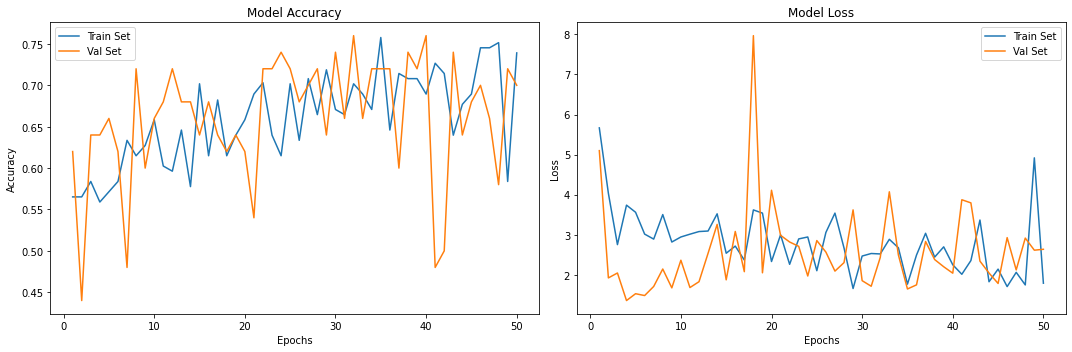

In [ ]:
# plot model performance
acc = xception_history.history['accuracy']
val_acc = xception_history.history['val_accuracy']
loss = xception_history.history['loss']
val_loss = xception_history.history['val_loss']
epochs_range = range(1, len(xception_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.720000


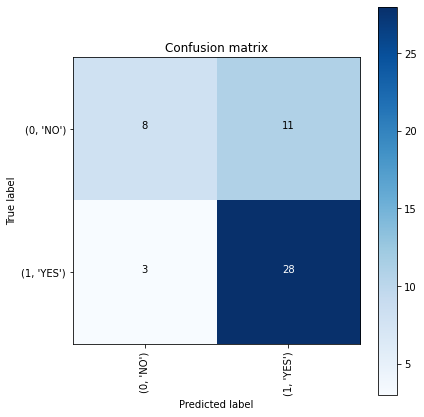

In [ ]:
# validate on val set
predictions = xception_.predict(X_val_prep)
predictions = [1 if x>0.95 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.720000
Precision: 0.717949
Recall: 0.903226
F1 score: 0.800000


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.353050
ROC AUC: 0.662139


Test Accuracy = 0.60


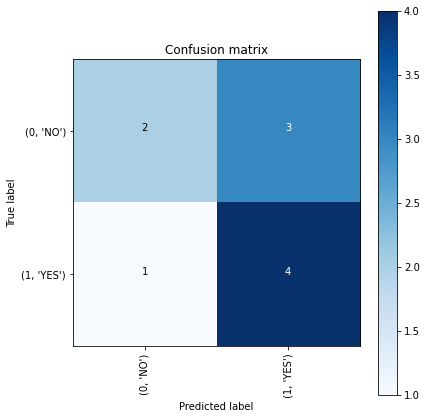

In [ ]:
# validate on test set
predictions = xception_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

## InceptionResnetV2

In [ ]:
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [ ]:
# load base model
#inception_resnet_V2_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
irnv2 = InceptionResNetV2(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMG_SIZE + (3,))
)

219062272/219055592 [==============================] - 1s 0us/step


In [ ]:
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization

NUM_CLASSES = 1

inception_resnet_v2_ = Sequential()


inception_resnet_v2_.add(irnv2)

inception_resnet_v2_.add(GlobalAveragePooling2D())
inception_resnet_v2_.add(layers.Dense(1,activation='sigmoid'))

inception_resnet_v2_.layers[0].trainable = False

inception_resnet_v2_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

inception_resnet_v2_.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])


inception_resnet_v2_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 1,537
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

irnv2_history = inception_resnet_v2_.fit_generator(
    train_generator,
    steps_per_epoch=7,
    epochs=50,
    validation_data=validation_generator,
    # callbacks=[early_stop]
)

end = time.time()
print(end - start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
7/7 [==============================] - 129s 17s/step - loss: 116.4537 - accuracy: 0.3768 - val_loss: 68.2674 - val_accuracy: 0.6200
Epoch 2/50
7/7 [==============================] - 115s 16s/step - loss: 73.2925 - accuracy: 0.5899 - val_loss: 16.5567 - val_accuracy: 0.6200
Epoch 3/50
7/7 [==============================] - 122s 20s/step - loss: 12.8288 - accuracy: 0.5394 - val_loss: 9.7448 - val_accuracy: 0.6200
Epoch 4/50
7/7 [==============================] - 118s 16s/step - loss: 17.9898 - accuracy: 0.6405 - val_loss: 3.9071 - val_accuracy: 0.5000
Epoch 5/50
7/7 [==============================] - 116s 17s/step - loss: 6.5829 - accuracy: 0.4945 - val_loss: 3.3624 - val_accuracy: 0.5400
Epoch 6/50
7/7 [==============================] - 115s 16s/step - loss: 6.0906 - accuracy: 0.4411 - val_loss: 1.4293 - val_accuracy: 0.6000
Epoch 7/50
7/7 [==============================] - 115s 16s/step - loss: 2.5348 - accuracy: 0.6504 - val_loss: 7.5234 - val_accuracy: 0.4800
Epoch 8/50
7/

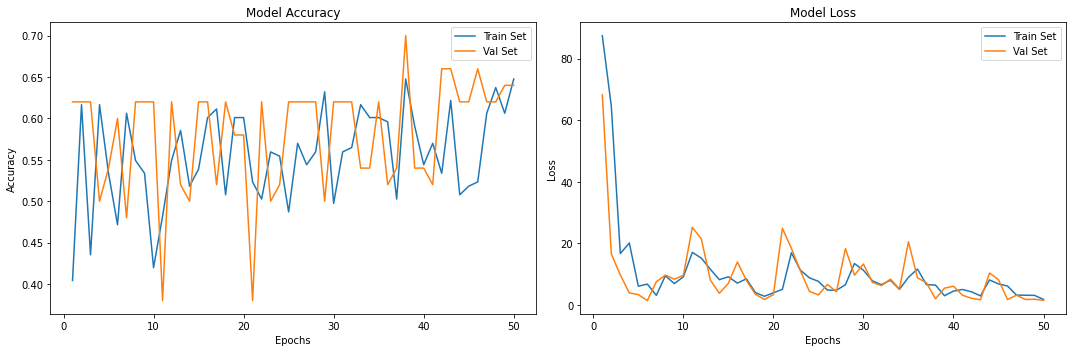

In [ ]:
# plot model performance
acc = irnv2_history.history['accuracy']
val_acc = irnv2_history.history['val_accuracy']
loss = irnv2_history.history['loss']
val_loss = irnv2_history.history['val_loss']
epochs_range = range(1, len(irnv2_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.600000


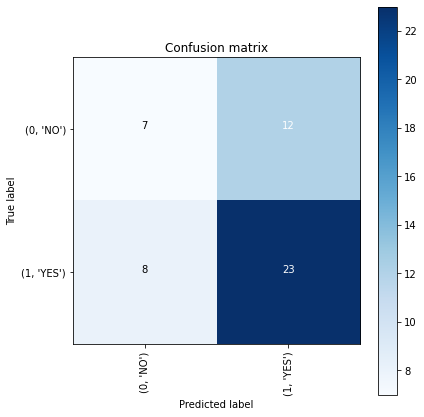

In [ ]:
# validate on val set
predictions = inception_resnet_v2_.predict(X_val_prep)
predictions = [1 if x>0.25 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.600000
Precision: 0.657143
Recall: 0.741935
F1 score: 0.696970


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.115044
ROC AUC: 0.555178


Test Accuracy = 0.60


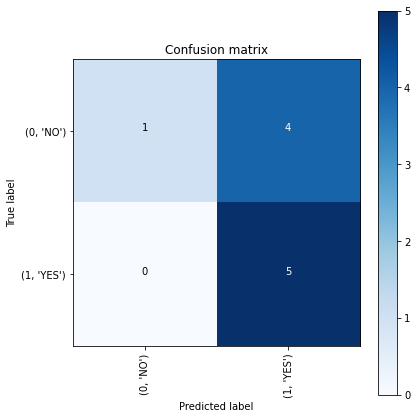

In [ ]:
# validate on test set
predictions = inception_resnet_v2_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)